In [1]:
from gausspy_pipeline import GausspyPipeline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pickle
from astropy.io import fits

# 1. Create pipeline and initialize all parameters
pipeline = GausspyPipeline(
    cube_file='../datacubes/spw0.fits',
    v1=10, v2=1500, x1=190, x2=210, y1=220, y2=240,
    alpha1=0.1, alpha2=12.0, snr_thresh=3.0,
    stack_vrange=(-200, 200), stack_dv=0.2
)


In [ ]:
# transform the fits cube to gausspy format
pipeline.prepare_input()

d = pickle.load(open('spectrum_for_gausspy.pickle', 'rb'))
print(d.keys())
print(len(d['x_values']), len(d['data_list']), len(d['errors']))
print(type(d['x_values'][0]), type(d['data_list'][0]), type(d['errors'][0]))
print(d['x_values'][0].shape, d['data_list'][0].shape, d['errors'][0].shape)

for i, spec in enumerate(d['data_list']):
    if np.any(np.isnan(spec)):
        print(f"Spectrum {i} 有 NaN！")
    elif np.any(np.isinf(spec)):
        print(f"Spectrum {i} 有 Inf！")
    elif np.all(spec == 0):
        print(f"Spectrum {i} 全部為 0！")
    elif len(spec) == 0:
        print(f"Spectrum {i} 長度為 0！")
    elif not np.issubdtype(spec.dtype, np.floating):
        print(f"Spectrum {i} 不是 float 類型！")


In [ ]:
#decomposition
pipeline.run_decomposition()

In [ ]:
#show the results
pipeline.count_fits()

In [ ]:
import pickle
with open('gausspy_result.pickle', 'rb') as f:
    result = pickle.load(f)
print(result.keys())

In [ ]:
fit_result_dic = pipeline.classify_fit_results('fit_result_dic.pickle')

In [ ]:
import pickle
with open('fit_result_dic.pickle', 'rb') as f:
    result = pickle.load(f)

print(result.keys())  # 應該會看到 dict_keys(['s', 'm', 'f'])

print(f"單峰（s）數量: {len(result['s'])}")
print(f"多峰（m）數量: {len(result['m'])}")
print(f"擬合失敗（f）數量: {len(result['f'])}")


In [ ]:
# Plot the results
# 單峰
# pipeline.plot_classified_fits(fit_result_pickle='fit_result_dic.pickle', category='s', plot_max=20)
# 多峰
pipeline.plot_classified_fits(fit_result_pickle='fit_result_dic.pickle', category='s', plot_max=20)


In [ ]:
# # Rest-frame (Gaussian-aligned) stacking
# v_rest, mean_rest, std_rest = pipeline.stack_restframe(plot=False)

# # Raw direct stacking
# v_raw, mean_raw, std_raw = pipeline.stack_raw_spectra(plot=False)

# # 1. Align the raw spectrum peak
# peak_idx = np.nanargmax(mean_raw)
# v_peak_raw = v_raw[peak_idx]
# v_raw_aligned = v_raw - v_peak_raw  # Align the main peak to v=0 km/s

# # 2. Set frequency (unit GHz)
# c = 299792.458
# freq_raw0 = 217.104980   # Center frequency of raw spectrum at v=0
# target_freq = 217.238530 # Frequency to be marked

# # 3. Calculate the velocity position of the frequency marker line
# v_target_raw = c * (1 - target_freq / freq_raw0)
# v_target_raw_aligned = v_target_raw - v_peak_raw

# # 4. Plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5))
# plt.plot(v_raw_aligned, mean_raw, label='Raw Stacked Spectrum (Aligned)', color='gray', linewidth=1.5)
# plt.plot(v_rest, mean_rest, label='Rest-frame Stacked Spectrum', color='black', linewidth=2)
# plt.axvline(0, linestyle='--', color='red', label='Aligned Main Peak (v=0 km/s)')
# plt.axvline(v_target_raw_aligned, linestyle='--', color='orange',
#             label=f'{target_freq:.3f} GHz ({v_target_raw_aligned:.1f} km/s)')
# plt.xlabel('Velocity (km/s)')
# plt.ylabel('Stacked Intensity')
# plt.title('Raw vs. Rest-frame Stacked Spectrum (with Marked Frequency)')
# plt.legend()
# plt.grid(True, linestyle=':')
# plt.tight_layout()
# plt.xlim(-200, 200)
# plt.show()


Stacking done: 375/400 spectra used (93.8%)
Stacked 400 raw spectra.


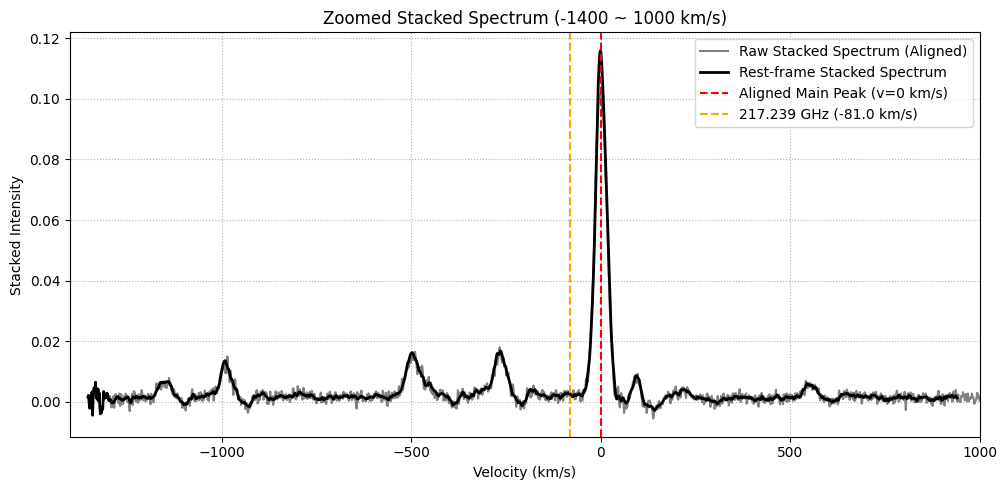

In [17]:
# 疊加
v_rest, mean_rest, std_rest = pipeline.stack_restframe(plot=False)
v_raw, mean_raw, std_raw = pipeline.stack_raw_spectra(plot=False)

pipeline.plot_stacked_zoom(
    v_rest, mean_rest,
    v_raw, mean_raw,
    target_freq= 217.238530, #DCN(3-2): 217.238530
    freq_raw0=217.104980,
    vmin=-1400, vmax=1000
)

Stacking done: 375/400 spectra used (93.8%)


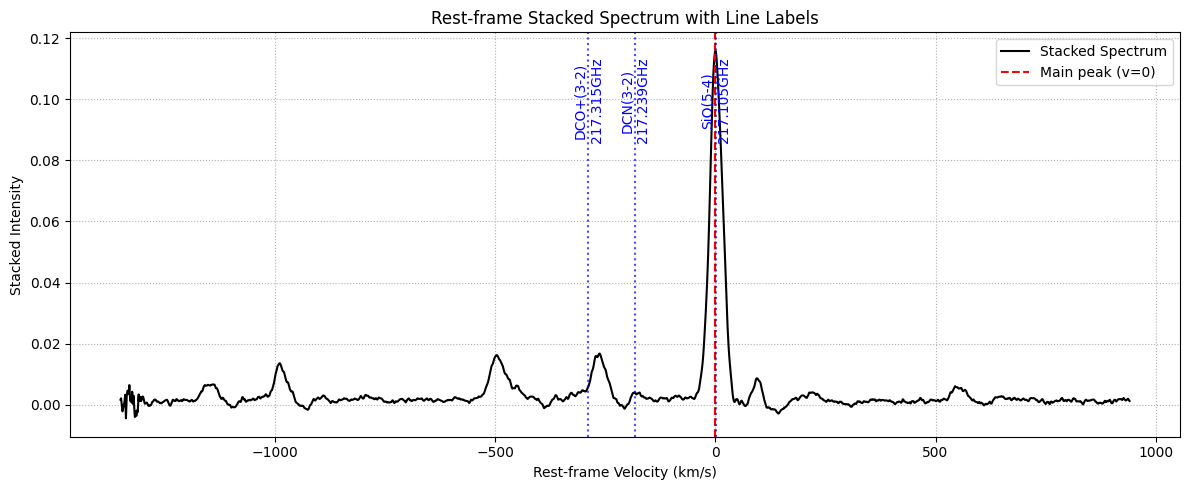

{'SiO(5-4)': 1.0527724506821414,
 'DCN(3-2)': -183.3616189921085,
 'DCO+(3-2)': -288.4729890903636}

In [4]:
v_grid, mean_spec, std_spec = pipeline.stack_restframe(plot=False)
# 常見分子線字典
line_dict = {
    "SiO(5-4)":   217.104980,
    "DCN(3-2)":   217.238530,
    "DCO+(3-2)":  217.314650,
    }

# restfreq 設為你當時疊加主峰的分子線頻率（如 SiO）
restfreq = 217.104980

# 假設 pipeline 是你的 GausspyPipeline 實例
pipeline.plot_lines_on_stack(v_grid, mean_spec, line_dict, restfreq=restfreq, label_offset=0.02)
